# Part 1: Replication

In [ ]:
#!pip install yfinance
#!pip install pandas_ta

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import time

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

from scipy.stats import gmean
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [ ]:

def load_data(ticker, start_date, end_date):
        """Load stock data and prepare features and target variable."""
        print(f"Downloading {ticker} stock data...")
        data = yf.download(ticker, start=start_date, end=end_date)
        data.index = pd.to_datetime(data.index)
        data.columns = ['Close','High','Low','Open','Volume']

        # Calculate a subset of relevant technical indicators
        print("Calculating technical indicators...")
        data.ta.strategy(ta.AllStrategy)

        data = data.loc["2009-12-31":,] # Keeping data for the studied period

        # Calculate the proportion of missing values per column
        na_pct = data.isnull().sum() / len(data)

        # Filter the columns that have no missing value
        columns_to_keep = na_pct[na_pct == 0].index

        # Keep only the filtered columns in the data
        data = data[columns_to_keep]

        # Assign target variable Γ (1 if price increases, 0 otherwise)
        data['Gamma'] = (data['Open'] - data['Open'].shift(1)).apply(lambda x: 1 if x > 0 else -1)

        # Drop rows with NaN values (due to indicator calculations)
        data.dropna(inplace=True)

        # Separate features (X) and target (y)
        X = data.drop(columns=['Gamma'])
        y = data['Gamma']

        # Normalize  features
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        return X, y

In [ ]:
class StockMLPClassifier:
    def __init__(self, ticker, start_date="2009-01-01", end_date="2020-01-01", missing_data_threshold=0.1, n_subsets=2):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.missing_data_threshold = missing_data_threshold  # Allow threshold for missing data
        self.n_subsets = n_subsets  # Number of subsets in which features should appear
        self.X = None
        self.y = None
        self.model = None
        self.selected_features = []
        self.avg_accuracy = None
        self.training_time = None
        self.epochs = None
        self.median_accuracy = None

    def load_data(self, X, y):
        self.X = X
        self.y = y

        print(f"Total features before selection: {self.X.shape[1]}")
        # Feature selection using Pearson correlation
        self.select_features()

    def select_features(self):
        """Select features using various statistical measures."""
        print("Selecting features using statistical measures...")

        if self.n_subsets > 0:
            selected_features_dict = {
                'low_variance': [],
                'lasso_coeffs': [],
                'rf_importances': [],
                'pca_variances': [],
                'mad': [],
                'dispersion_ratio': []
            }

            # Low Variance Selection
            low_variance_features = self.X.var()
            sorted_low_variance = sorted(zip(self.X.columns, low_variance_features), key=lambda x: x[1], reverse=True)
            selected_features_dict['low_variance'] = [x[0] for x in sorted_low_variance[:int(len(sorted_low_variance) * 0.25)]]

            # Lasso Feature Selection
            lasso_selector = LassoCV().fit(self.X, self.y)
            lasso_coeffs = np.abs(lasso_selector.coef_)
            sorted_lasso = sorted(zip(self.X.columns, lasso_coeffs), key=lambda x: x[1], reverse=True)
            selected_features_dict['lasso_coeffs'] = [x[0] for x in sorted_lasso[:int(len(sorted_lasso) * 0.25)]]

            # Random Forest Feature Importance
            rf_selector = RandomForestClassifier(n_estimators=100, random_state=42).fit(self.X, self.y)
            sorted_rf = sorted(zip(self.X.columns, rf_selector.feature_importances_), key=lambda x: x[1], reverse=True)
            selected_features_dict['rf_importances'] = [x[0] for x in sorted_rf[:int(len(sorted_rf) * 0.25)]]

            # PCA Feature Selection
            pca = PCA(n_components=self.X.shape[1]).fit(self.X)
            sorted_pca = sorted(zip(self.X.columns, pca.explained_variance_ratio_), key=lambda x: x[1], reverse=True)
            selected_features_dict['pca_variances'] = [x[0] for x in sorted_pca[:int(len(sorted_pca) * 0.25)]]

            # Mean Absolute Deviation (MAD)
            mad = self.X.mad()
            sorted_mad = sorted(zip(self.X.columns, mad), key=lambda x: x[1], reverse=True)
            selected_features_dict['mad'] = [x[0] for x in sorted_mad[:int(len(sorted_mad) * 0.25)]]

            # Dispersion Ratio
            dispersion_ratio = self.X.mean() / self.X.apply(lambda x: gmean(x[x > 0]))
            sorted_dr = sorted(zip(self.X.columns, dispersion_ratio), key=lambda x: x[1], reverse=True)
            selected_features_dict['dispersion_ratio'] = [x[0] for x in sorted_dr[:int(len(sorted_dr) * 0.25)]]

            # Combine selected features across methods
            feature_count = {}
            for features in selected_features_dict.values():
                for feature in features:
                    feature_count[feature] = feature_count.get(feature, 0) + 1

            self.selected_features = [feature for feature, count in feature_count.items() if count >= self.n_subsets]
        else:
            self.selected_features = self.X.columns.tolist()

        if not self.selected_features:
            raise ValueError("No features selected. Adjust n_subsets or selection criteria.")

        self.X = self.X[self.selected_features]
        print(f"Selected {len(self.selected_features)} features after selection.")

    def configure_mlp(self):
        """Configure an MLP classifier with an appropriate hidden layer size."""
        hidden_layer_sizes = (self.X.shape[1] + len(np.unique(self.y))) // 2  # Simplified hidden layer size calculation
        self.model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation='logistic',  # Changed to ReLU for better performance
            solver='lbfgs',  # Changed to Adam optimizer for better convergence
            batch_size='auto',
            learning_rate='adaptive',
            learning_rate_init=0.03,  # Adjusted learning rate
            max_iter=5000,  # Reduced max iterations
            momentum=0.2,
            random_state=np.random.get_state()[1][0],
            early_stopping=False # Disabled early stopping
        )


    def cross_validate(self, n_splits=10):
        """Perform Stratified K-Fold cross-validation."""
        print(f"Performing {n_splits}-fold cross-validation...")
        cv_generator = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_accuracies = []

        for train_index, val_index in cv_generator.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_index], self.X.iloc[val_index]
            y_train, y_val = self.y.iloc[train_index], self.y.iloc[val_index]

            # Train the MLP model
            self.model.fit(X_train, y_train)

            # Evaluate the model
            y_val_pred = self.model.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)
            cv_accuracies.append(accuracy)

        avg_accuracy = np.mean(cv_accuracies)
        median_accuracy = np.median(cv_accuracies)
        print(f"Average cross-validation accuracy: \t{avg_accuracy:.4f}")
        print("-"*100,"\n")
        self.avg_accuracy = avg_accuracy
        self.median_accuracy = median_accuracy
        return avg_accuracy

    def evaluate(self, test_size=0.2):
        """Train the model on the full dataset and evaluate on a test set."""
        print(f"Splitting data into training and test sets ({test_size*100:.0f}% test)...")
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=42)

        # Start timer for training time
        start_time = time.time()

        # Train the MLP model
        self.model.fit(X_train, y_train)

        # Calculate training time
        self.training_time = time.time() - start_time
        self.epochs = self.model.n_iter_

        # Evaluate on the test set
        y_test_pred = self.model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Test set accuracy : \t{test_accuracy:.4f}")
        print("-"*20,"\n")

        return test_accuracy

    def fit(self, X, y):
        """Execute the full process: Load data, configure MLP, cross-validate, and evaluate."""
        self.load_data(X, y)
        self.configure_mlp()
        self.cross_validate()
        self.evaluate()


In [ ]:
ticker="EWZ"
X, y = load_data(ticker=ticker, start_date = "2009-01-01", end_date="2020-01-01")

[*********************100%***********************]  1 of 1 completed

Calculating technical indicators...



0it [00:00, ?it/s]

[X] Please install TA-Lib to use 2crows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3blackcrows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3inside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3linestrike. (pip install TA-Lib)
[X] Please install TA-Lib to use 3outside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3starsinsouth. (pip install TA-Lib)
[X] Please install TA-Lib to use 3whitesoldiers. (pip install TA-Lib)
[X] Please install TA-Lib to use abandonedbaby. (pip install TA-Lib)
[X] Please install TA-Lib to use advanceblock. (pip install TA-Lib)
[X] Please install TA-Lib to use belthold. (pip install TA-Lib)
[X] Please install TA-Lib to use breakaway. (pip install TA-Lib)
[X] Please install TA-Lib to use closingmarubozu. (pip install TA-Lib)
[X] Please install TA-Lib to use concealbabyswall. (pip install TA-Lib)
[X] Please install TA-Lib to use counterattack. (pip install TA-Lib)
[X] Please install TA-Lib to use darkcloudcover. (pip instal

131it [00:05, 23.25it/s]


In [ ]:
results = {}

for n in range(7):
    mlp_classifier = StockMLPClassifier(ticker=ticker, n_subsets=n)
    mlp_classifier.fit(X, y)
    results[n] = mlp_classifier

Total features before selection: 213
Selecting features using statistical measures...
Selected 213 features after selection.
Performing 10-fold cross-validation...
Average cross-validation accuracy: 	0.7731
---------------------------------------------------------------------------------------------------- 

Splitting data into training and test sets (20% test)...
Test set accuracy : 	0.7798
-------------------- 

Total features before selection: 213
Selecting features using statistical measures...


/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Selected 169 features after selection.
Performing 10-fold cross-validation...
Average cross-validation accuracy: 	0.7704
---------------------------------------------------------------------------------------------------- 

Splitting data into training and test sets (20% test)...
Test set accuracy : 	0.7897
-------------------- 

Total features before selection: 213
Selecting features using statistical measures...


/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Selected 87 features after selection.
Performing 10-fold cross-validation...
Average cross-validation accuracy: 	0.7700
---------------------------------------------------------------------------------------------------- 

Splitting data into training and test sets (20% test)...
Test set accuracy : 	0.7738
-------------------- 

Total features before selection: 213
Selecting features using statistical measures...


/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Selected 44 features after selection.
Performing 10-fold cross-validation...
Average cross-validation accuracy: 	0.7517
---------------------------------------------------------------------------------------------------- 

Splitting data into training and test sets (20% test)...
Test set accuracy : 	0.7718
-------------------- 

Total features before selection: 213
Selecting features using statistical measures...


/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Selected 16 features after selection.
Performing 10-fold cross-validation...
Average cross-validation accuracy: 	0.7561
---------------------------------------------------------------------------------------------------- 

Splitting data into training and test sets (20% test)...
Test set accuracy : 	0.7381
-------------------- 

Total features before selection: 213
Selecting features using statistical measures...


/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Selected 2 features after selection.
Performing 10-fold cross-validation...
Average cross-validation accuracy: 	0.5765
---------------------------------------------------------------------------------------------------- 

Splitting data into training and test sets (20% test)...
Test set accuracy : 	0.5774
-------------------- 

Total features before selection: 213
Selecting features using statistical measures...


/opt/tljh/user/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: No features selected. Adjust n_subsets or selection criteria.

In [ ]:
results.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [ ]:
summary = pd.DataFrame({"n_subsets": list(results.keys()),
                       "Features": [len(mlp.selected_features) for mlp in results.values()],
                       "Mean Accuracy (%)": [mlp.avg_accuracy*100 for mlp in results.values()],
                        "Median Accuracy (%)": [mlp.median_accuracy*100 for mlp in results.values()],
                       "Training time (s)": [mlp.training_time for mlp in results.values()],
                       "Epoch": [mlp.epochs for mlp in results.values()]})

In [ ]:
summary

,n_subsets,Features,Mean Accuracy (%),Median Accuracy (%),Training time (s),Epoch
0,0,213,77.314868,77.182540,47.993394,84
1,1,169,77.038038,76.737494,44.399523,88
2,2,87,76.995352,77.335895,17.995603,115
3,3,44,75.170429,75.547018,24.093608,205
4,4,16,75.606305,75.595238,40.692792,617
5,5,2,57.647821,57.142857,0.036625,46


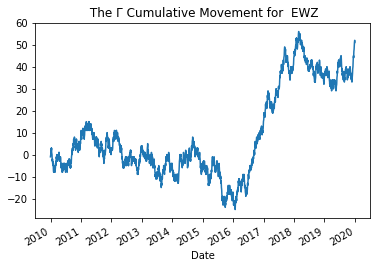

In [ ]:
import matplotlib.pyplot as plt

y_cum = y.cumsum()
y_cum.plot(title=f" The Γ Cumulative Movement for  EWZ")

# Save the figure
plt.savefig(f"gamma_cumulative_movement_EWZ.png", dpi=300, bbox_inches='tight')


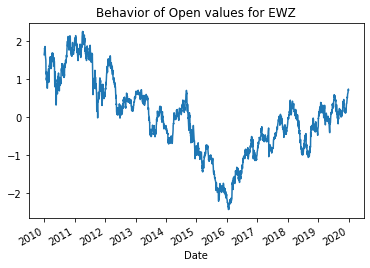

In [ ]:
X['Open'].plot(title=f'Behavior of Open values for EWZ')
plt.savefig(f"open_price_movement_EWZ.png", dpi=300, bbox_inches='tight')

In [ ]:
results[4].selected_features

['AOBV_LR_2',
 'AOBV_SR_2',
 'CG_10',
 'STOCHk_14_3_3',
 'Open',
 'DMP_14',
 'open_Z_30_1',
 'low_Z_30_1',
 'CCI_14_0.015',
 'BOP',
 'close_Z_30_1',
 'high_Z_30_1',
 'BBP_5_2.0',
 'AMATe_LR_8_21_2',
 'AROONU_14',
 'AROOND_14']

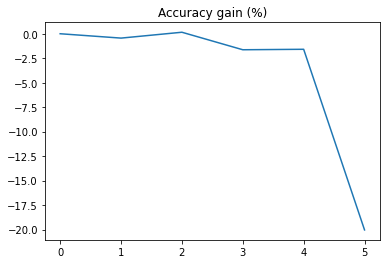

In [ ]:
summary["Accuracy gain (%)"] = summary["Median Accuracy (%)"] - summary.loc[0,"Median Accuracy (%)"]
summary["Accuracy gain (%)"].plot(title = "Accuracy gain (%)" )
plt.savefig(f"Accuracy_gain_EWZ.png", dpi=300, bbox_inches='tight')

# Part 2:  Evaluating One Particular Type of Alternative Data

**User Guide: Social Media Data in Finance and Business**

Today, the commonly used type of alternative data in finance and business is social media data. Social media data provide real-time insights about customers' opinions and engagements,  and public sentiment. These are key information that can be used to make decisions in finance and business. This guide offers a comprehensive overview of social media data as an alternative data source by exploring the following:

1)	**Sources of Data**

Social media data are collected from different online platforms where users engage with each other, share opinions, generate content, and express their opinions. These online platforms include the following. First, Facebook, data includes engagement on financial pages and investors' sentiment in the form of public posts, reactions, and comments. Second, X(Twitter), data includes stock or crypto mentions, new reactions, and financial discussion in the form of tweets, retweets, user interaction, and hashtags. Third,  LinkedIn, data includes companies’ news, job postings, and professional discussions. Fourth,  Reddit, data includes investors’ trends and sentiment analysis. Fifth, Stocktwits, data includes stock discussions, which is the core business of the platform. Sixth, YouTube, data includes perspectives on trends and opinions provided by video content, comments, and engagement metrics.
2)	Types of Data
Social media data includes both structured and unstructured data formats, which are categorized into the following types. First, textual data, this type of data includes users’ tweets, posts, reactions, comments, and reviews. It’s mostly used in sentiment analysis, trends, and topics. Second, sentiment data, this data type includes user’s opinions, attitudes, and emotions expressed in text form. It’s used in sentiment analysis to measure public perception about a product or market trends. Third, metadata, this data type includes additional information like user profiles, timestamps, geolocation, and engagement metrics (likes, retweets, and shares). This provides context and improves the analysis of social media data. Fourth, multimedia data, this data type includes content like videos, images, and audio shared by social media users that can drive public perceptions. Fifth, network data, this type of data includes information about the relationship between users for example friends, interactions connections, and followers.


3)	**Quality of Data**

To produce accurate and reliable analysis results that can be used in making informed financial decisions, researchers or analysts ought to ensure that social media data is of high quality. The quality of social media data is influenced by the following factors. First, data accuracy.  Social media data can be distorted by misinformation, the use of bots, and fake social media accounts. So,  filtering out unreliable sources is key to ensuring data validity and accuracy. Second, data relevance.  To ensure the relevance of data, social media data needs to align with the business or financial question that’s to be addressed. For instance, tweets related to a specific stock are more relevant for investment analysis than general tweets. Third, bias.  In some cases, social media users might not be representative of the whole population, this can lead to sampling biases. Therefore, cross-validating information with other relevant data sources can minimize bias issues. Fourth, the completeness of data.  Social media data need to be a representative dataset with few or no missing values. Data with too many missing values and incomplete data can adversely affect analysis and thereby the results. Fifth, timeliness. Where market conditions are prone to change rapidly, especially in the stock market and forex market, social media data need to be real-time or near-real-time data to ensure they are valuable for financial application.
Researchers and analysts can ensure high-quality social data by doing the following. First, use of filters to get rid of spam, misinformation, and bot-generated content. Second, using verified APIs to obtain reliable and structured data. Finally, cross-validation of social media data with external sources. To ensure robustness and avoid biases, researchers can validate social media findings with reliable external sources.


**4)	Ethical Issues**

To ensure responsible practices in the use of social media data, researchers ought to shun or mitigate ethical issues that come with its use. First, researchers ought to avoid privacy issues. Most social media users do not consent to the use of their data by third parties. Researchers need to use publicly available data to avoid interference with the privacy of social media users.  Second, researchers ought to avoid transparency issues.  Researchers ought to communicate clearly and openly to social media users how their data is collected and is to be used.  Third, researchers also ought to avoid anonymization issues.  This arises when anonymized information is traced back to the owner. To avoid such a problem, researchers ought to use secure anonymization methods to safeguard the identities of social media users. Finally, researchers ought to avoid compliance issues to avoid reputational and legal risks.  By adhering to social media's general data protection regulations, researchers can avoid risks that come with non-compliance.

**5)	Python Code to Import and Structure into Useful Data Structures**

In this case, we shall focus on how you can retrieve stock data from X(Twitter) and structure it into useful data.

In [ ]:
# load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
from textblob import TextBlob

# identify Twitter API credentials
api_key = "replace with your_actual_api_key"
api_secret_key = "replace with your_actual_api_secret_key"
access_token = "replace with your_actual_access_token"
access_token_secret = "replace with your_actual_access_token_secret"

# authenticate with Twitter API
auth = tweepy.OAuth1UserHandler(api_key, api_secret_key, access_token,
                                access_token_secret)
api = tweepy.API(auth)

# retrieve tweets related to a stock
query = "#Stock Ticker"
tweets = tweepy.Cursor(api.search_tweets, q = query, lang="en",
                       count=200).items(200)

# structure tweets and  about the a stock into a dataframe
data = []
for tweet in tweets:
    data.append({
        'user': tweet.user.screen_name,
        'location': tweet.user.location,
        'created_at': tweet.created_at,
        'text': tweet.text,
        'retweets': tweet.retweet_count,
        'likes': tweet.favorite_count
    })

stock_data = pd.DataFrame(data)


**6)	Exploratory Data Analysis of Sample Data**

To understand the characteristics of the imported data, we need to conduct exploratory data analysis. This will include plot graphs and computation of basic statistics like count, of the key elements of data.

In [ ]:
# perform sentiment analysis
## create sentiment variable using TextBlob function
stock_data['sentiment'] = stock_data['text'].apply(lambda x:
                                                   TextBlob(x).sentiment.polarity)
## categorize sentiments into negative, neutral or positive
stock_data["sentiment category"] = stock_data["sentiment"].apply(lambda x:
 "Negative" if x < 0 else "Positive" if x > 0 else "Neutral")

# display sentiments distribution
print(stock_data["sentiment category"].value_counts())

# plot the sentiments distribution
sns.countplot(x="sentiment category", data=stock_data, palette="coolwarm")
plt.title("Sentiment Distribution of X(Twitter) Data")
plt.xlabel("Sentiment Category")
plt.ylabel("Tweet Count")
plt.show()


**7)	Short Literature Search That Links to Papers Citing Research**

Various studies have demonstrated the importance of social media data in finance especially in the investment of stocks and cryptocurrencies. Twitter sentiments can significantly be used to forecast stock price movements, especially for frequently discussed stocks (Sul et al., 23).   Bartov et al. found that aggregated opinions from individuals' tweets correlate with firms’ future earnings and returns (20).  Moreover, other research like Siganos et al., emphasized the relationship between Facebook investor sentiment and stock volatility (1). Finally,  the analysis by Kraaijeveld and De Smedt about cryptocurrency discussions on Twitter revealed that there’s a strong predictive relationship between price movements and Twitter (X) sentiment(14).  All these studies demonstrate the significance of social media data in investment and financial decision-making.

                             **Work Cited**

Bartov, Eli, et al. “Can Twitter Help Predict Firm-Level Earnings and Stock Returns?” The Accounting Review, vol. 93, no. 3, 1 July 2017, pp. 25–57, doi:10.2308/accr-51865.


Kraaijeveld, Olivier, and Johannes De Smedt. “The Predictive Power of Public Twitter Sentiment for Forecasting Cryptocurrency Prices.” Journal of International Financial Markets, Institutions and Money, vol. 65, Mar. 2020, p. 101188, doi:10.1016/j.intfin.2020.101188.


Siganos, Antonios, et al. “Facebook’s Daily Sentiment and International Stock Markets.” Journal of Economic Behavior &amp; Organization, vol. 107, Nov. 2014, pp. 730–743, doi:10.1016/j.jebo.2014.06.004.


Sul, Hong Kee, et al. “Trading on Twitter: Using Social Media Sentiment to Predict Stock Returns.” Decision Sciences, vol. 48, no. 3, 23 June 2016, pp. 454–488, doi:10.1111/deci.12229.